# Import libraries

In [3]:
!pip install transformers
!pip install keras_preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.2 MB/s eta 0:00:00


In [22]:
import numpy as np
import pandas as pd
import transformers
import tensorflow as tf
import nltk

from transformers import pipeline
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib. pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

In [6]:
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Kaggle file management

In [1]:
# import python modules
import os
 
# directory name from which
# we are going to extract our files with its size
path = "/kaggle/working/"
 
# Get list of all files only in the given directory
fun = lambda x : os.path.isfile(os.path.join(path,x))
files_list = filter(fun, os.listdir(path))
 
# Create a list of files in directory along with the size
size_of_file = [
    (f,os.stat(os.path.join(path, f)).st_size)
    for f in files_list
]
# Iterate over list of files along with size
# and print them one by one.
for f,s in size_of_file:
    print("{} : {}MB".format(f, round(s/(1024*1024),3)))

Roberta_polarity_emotion_finalLayers.h5 : 1427.336MB
__notebook_source__.ipynb : 0.0MB
Roberta_suicide_label_finalLayers.h5 : 1427.3MB


In [18]:
os.remove("/kaggle/working/Roberta_polarity_emotion.h5")

# Remove weird Characters

In [8]:
# Load data into a DataFrame
data = pd.read_excel("/kaggle/input/suicide-dataset/majority_labled_data.xlsx")

# Define the characters to keep
allowed_chars = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789?,.![]“„%‚{}’:@-_=()+ '

# Create an empty list to store the unwanted characters
unwanted_chars = []

# Iterate over each row in the DataFrame
for index, row in data.iterrows():
    text = row['text']
    # Check if the text variable contains a string value
    if isinstance(text, str):
        # Iterate over each character in the text
        for char in text:
            # If the character is not in the allowed_chars string
            if char not in allowed_chars:
                # Add the character to the unwanted_chars list
                unwanted_chars.append(char)

# Convert the unwanted_chars list to a set to remove duplicates
unwanted_chars = set(unwanted_chars)

# Print the unwanted characters
print(unwanted_chars)

{'Œ', '\t', '²', '™', 'ð', 'ª', 'â', '¢', '¦', 'Š', '©', '"', '\x81', '\\', '¸', '‘', 'Ž', '€', '¬', '«', '†', '\x8f', 'Ã', '¯', 'Å', '±', '$', '¿', '^', '|', '¥', 'š', '§', "'", 'ƒ', '‡', 'Â', '£', 'ã', 'Ÿ', '~', '°', '/', '¶', '\xa0', 'Ä', '&', 'ž', '\xad', ';', 'ï', '\x8d', '*', '\n', 'œ', '”', '…', '¤', '‹', '‰', '»', '½', 'º', '¹', '˜', '¡', '´', '•', 'ˆ', '\x90', '#', '\x9d'}


In [9]:
def remove_chars(text):
    # Check if text is NaN
    if pd.isna(text):
        return text
    # Define the characters you want to keep
    allowed_chars = set('abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789?,.![]“„%‚{}’:@-_=()+"‘ ')
    # Remove all characters that are not in the allowed_chars set
    cleaned_text = ''.join(c for c in text if c in allowed_chars)
    return cleaned_text

# Import h5 models and test output

In [17]:
from transformers import TFRobertaModel

# Load the first Keras model
suicide_model = tf.keras.models.load_model('Roberta_suicide_label_finalLayers.h5', custom_objects={'TFRobertaModel': TFRobertaModel})

# Load the second Keras model
polarity_emotion_model = tf.keras.models.load_model('Roberta_polarity_emotion_finalLayers.h5', custom_objects={'TFRobertaModel': TFRobertaModel})

# Prepare test text
test_text = "This is a test text"
tokenizer = transformers.RobertaTokenizer.from_pretrained('roberta-base')
test_text_encoded = tokenizer.encode(test_text, add_special_tokens=True, truncation=True, max_length=512)
test_text_padded = pad_sequences([test_text_encoded], maxlen=512, dtype="int32", value=0, truncating="post")

# Make predictions with the first model
suicide_output = suicide_model.predict(test_text_padded)
predicted_index = np.argmax(suicide_output)
index_to_suicide = {0: 'anxiety', 1: 'suicide watch', 2: 'bipolar', 3: 'depression', 4: 'off my chest'}
predicted_suicide_name = index_to_suicide[predicted_index]

# Make predictions with the second model
polarity_emotion_output = polarity_emotion_model.predict(test_text_padded)

# Define the label names for the second model
label_names = ['Pos', 'Neg', 'anger', 'fear', 'hopefullness', 'hopelessness', 'joy', 'sadness', 'disgust']

print(f"Suicide Risk (First Model): {predicted_suicide_name}")

# Print the predicted probabilities for each label
print("Polarity and Emotions (Second Model):")
for label_name, probability in zip(label_names, polarity_emotion_output[0]):
    print(f"{label_name}: {probability:.2f}")

1/1 [==============================] - 3s 3s/step
Suicide Risk (First Model): depression
Polarity and Emotions (Second Model):
Pos: 0.02
Neg: 0.01
anger: 0.01
fear: 0.00
hopefullness: 0.00
hopelessness: 0.00
joy: 0.01
sadness: 0.00
disgust: 0.00


# Classification Reports

## Load Dataset

In [6]:
# Load your data into a DataFrame(My labled data)
data = pd.read_excel("/kaggle/input/suicide-dataset/majority_labled_data.xlsx")
# We removed clamness column as it only has 20 support ( rows )
data.drop('calmness', axis=1, inplace=True)
data = data.head(5000-1)
data['text'] = data['text'].apply(remove_chars)
data.tail()

,text,suicide_label,Pos,Neg,anger,fear,hopefullness,hopelessness,joy,sadness,disgust
4994,I find it cruel that life is only somewhat bea...,self.depression,0,1,0,0,0,1,0,1,0
4995,My mum stopped controlling my meds... she was ...,self.bipolar,0,1,0,0,0,0,0,1,0
4996,Teachers cause it Whenever Im in class and hav...,self.Anxiety,0,1,0,1,0,0,0,0,0
4997,Depicting Bipolar Disorder In Art Hello! Im a ...,self.bipolar,1,0,0,0,1,0,0,0,0
4998,(First time Poster) Posting because Im terrifi...,self.Anxiety,0,1,0,1,0,0,0,0,0


# RoBERTa Suicide Label + CrossValidation Performance

In [18]:
# split into input (X) and output (Y) variables
X = data['text'].tolist()
Y = data['suicide_label']

# convert string labels to integer labels
le = LabelEncoder()
Y = le.fit_transform(Y)

# convert labels to one-hot encoded format
Y = to_categorical(Y)

# print the mapping between original string labels and integer labels
for i, label in enumerate(le.classes_):
    print(f"{label}: {i}")

self.Anxiety: 0
self.SuicideWatch: 1
self.bipolar: 2
self.depression: 3
self.offmychest: 4


In [17]:
# split into input (X) and output (Y) variables
X = data['text'].tolist()
Y = data['suicide_label']

# convert string labels to integer labels
le = LabelEncoder()
Y = le.fit_transform(Y)

# convert labels to one-hot encoded format
Y = to_categorical(Y)

# create a tokenizer and encode the input text
tokenizer = transformers.RobertaTokenizer.from_pretrained('roberta-base')
X_encoded = [tokenizer.encode(text, add_special_tokens=True, truncation=True, max_length=512) for text in X]

# pad the encoded sequences to have the same length
max_length = max([len(seq) for seq in X_encoded])
X_padded = pad_sequences(X_encoded, maxlen=max_length, dtype="long", value=0, truncating="post")

# split data into training and test sets using train_test_split function with random_state set to a fixed integer value.
X_train_padded, X_test_padded, Y_train,Y_test=train_test_split(X_padded,Y,test_size=0.2,random_state=42)

# create the model using TFRobertaModel
model = transformers.TFRobertaModel.from_pretrained('roberta-base')
input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32,name='input_ids')
output=model(input_ids)[0]
output=tf.keras.layers.Dropout(0.5)(output)
output=tf.keras.layers.GlobalAveragePooling1D()(output)
#softmax function is used for multi-class classification problems
output=tf.keras.layers.Dense(5,activation='softmax')(output)
model=tf.keras.Model(inputs=input_ids,outputs=output)

# compile the model with categorical_crossentropy loss for multi-class classification.
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# define early stopping criteria.
early_stopping_callback=EarlyStopping(monitor='val_loss',patience=3)

# fit the model on your dataset with early stopping.
model.fit(X_train_padded,Y_train,batch_size=11,epochs=50,callbacks=[early_stopping_callback],validation_data=(X_test_padded,Y_test))

# generate predictions on test set and print classification report
y_pred_proba=model.predict(X_test_padded)
y_pred=np.argmax(y_pred_proba,axis=1)
class_names = ['Anxiety', 'SuicideWatch', 'bipolar', 'depression', 'offmychest']
print(classification_report(np.argmax(Y_test,axis=1), y_pred, target_names=class_names))

tf.keras.backend.clear_session()

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/50
364/364 [==============================] - 574s 1s/step - loss: 1.5073 - accuracy: 0.3643 - val_loss: 1.2836 - val_accuracy: 0.5020
Epoch 2/50
364/364 [==============================] - 526s 1s/step - loss: 0.9826 - accuracy: 0.6172 - val_loss: 0.8832 - val_accuracy: 0.6440
Epoch 3/50
364/364 [==============================] - 526s 1s/step - loss: 0.7795 - accuracy: 0.7029 - val_loss: 0.8915 - val_accuracy: 0.6620
Epoch 4/50
364/364 [==============================] - 526s 1s/step - loss: 0.6262 - accuracy: 0.7649 - val_loss: 0.9230 - val_accuracy: 0.6570
Epoch 5/50
32/32 [==============================] - 44s 1s/step
              precision    recall  f1-score   support

     Anxiety       0.70      0.84      0.76       170
SuicideWatch       0.60      0.72      0.66       188
     bipolar       0.94      0.54      0.69       150
  depression       0.62      0.64      0.63       358
  offmychest       0.60      0.52      0.56       134

    accuracy                          

In [18]:
model.save("Roberta_suicide_label_finalLayers.h5")

# Cross validation Performance

In [7]:
#data loaded above

# split into input (X) and output (Y) variables
X = data['text'].tolist()
Y = data['suicide_label']

# convert string labels to integer labels
le = LabelEncoder()
Y = le.fit_transform(Y)

# one-hot encode the integer labels
Y = to_categorical(Y)

# create a tokenizer and encode the input text
tokenizer = transformers.RobertaTokenizer.from_pretrained('roberta-base')
X_encoded = [tokenizer.encode(text, add_special_tokens=True, truncation=True, max_length=512) for text in X]

# pad the encoded sequences to have the same length
max_length = max([len(seq) for seq in X_encoded])
X_padded = pad_sequences(X_encoded, maxlen=max_length, dtype="long", value=0, truncating="post")

n_splits = 5
#StratifiedKFold was used becuase we have good amount of each label
#ie. same protion of each label in each fold
skf = StratifiedKFold(n_splits=n_splits)

# define early stopping criteria.
early_stopping_callback=EarlyStopping(monitor='val_loss',patience=4)

fold = 0

VALIDATION_ACCURACY = []
VALIDATION_LOSS = []
                                #Below splits training and test set
for train_index, test_index in skf.split(X_padded,np.argmax(Y,axis=1)):
    fold+=1
    print(f"Fold #{fold}")
    
    X_train_padded, X_test_padded = X_padded[train_index], X_padded[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    
    # create the model using TFRobertaModel
    model = transformers.TFRobertaModel.from_pretrained('roberta-base')
    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32,name='input_ids')
    output=model(input_ids)[0]
    output=tf.keras.layers.Dropout(0.5)(output)
    output=tf.keras.layers.GlobalAveragePooling1D()(output)
    output=tf.keras.layers.Dense(5,activation='softmax')(output)
    model=tf.keras.Model(inputs=input_ids,outputs=output)

    # compile the model with categorical_crossentropy loss for multi-class classification.
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    
    # define checkpoint callback to save best model for each fold.
    checkpoint_callback = ModelCheckpoint(f'best_model_fold_{fold}.h5', monitor='val_loss', save_best_only=True)
    
    # fit the model on your dataset with early stopping.
    model.fit(X_train_padded,
              Y_train,batch_size=11,
              epochs=50,
              callbacks=[early_stopping_callback, checkpoint_callback],
              validation_data=(X_test_padded,Y_test))
    
    # load best model for current fold
    model.load_weights(f'best_model_fold_{fold}.h5')
    
    # evaluate best model on validation data
    results = model.evaluate(X_test_padded,Y_test)
    
    # store evaluation results
    VALIDATION_ACCURACY.append(results[1])
    VALIDATION_LOSS.append(results[0])
    
    # generate predictions on test set and store them
    pred = model.predict(X_test_padded)
    
    tf.keras.backend.clear_session()
        
print("Accuracy Values= ", VALIDATION_ACCURACY)
print("Loss Values = " , VALIDATION_LOSS)

print("AVG Accuracy = ", np.mean(VALIDATION_ACCURACY))
print("AVG Loss = " ,  np.mean(VALIDATION_LOSS))

mean_accuracy = np.mean(VALIDATION_ACCURACY)
mean_loss = np.mean(VALIDATION_LOSS)

# These values represent the average performance of the model on the validation data 
#across all folds of cross-validation. They provide an estimate of how well the model 
#is likely to perform on unseen data.

import os
# remove saved models
for fold in range(1, n_splits+1):
    file_path = f'best_model_fold_{fold}.h5'
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f'Removed file: {file_path}')
    else:
        print(f'File not found: {file_path}')


Fold #1


Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/50
364/364 [==============================] - 581s 1s/step - loss: 1.3640 - accuracy: 0.4371 - val_loss: 0.9785 - val_accuracy: 0.6090
Epoch 2/50
364/364 [==============================] - 528s 1s/step - loss: 0.8801 - accuracy: 0.6664 - val_loss: 0.8506 - val_accuracy: 0.6570
Epoch 3/50
364/364 [==============================] - 529s 1s/step - loss: 0.6743 - accuracy: 0.7542 - val_loss: 0.8397 - val_accuracy: 0.6780
Epoch 4/50
364/364 [==============================] - 525s 1s/step - loss: 0.5101 - accuracy: 0.8100 - val_loss: 0.9804 - val_accuracy: 0.6630
Epoch 5/50
364/364 [==============================] - 524s 1s/step - loss: 0.3469 - accuracy: 0.8720 - val_loss: 1.0418 - val_accuracy: 0.6640
Epoch 6/50
364/364 [==============================] - 525s 1s/step - loss: 0.2269 - accuracy: 0.9195 - val_loss: 1.3003 - val_accuracy: 0.6750
Epoch 7/50
32/32 [==============================] - 43s 1s/step
Fold #2


Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/50
364/364 [==============================] - 574s 1s/step - loss: 1.5494 - accuracy: 0.3478 - val_loss: 1.5160 - val_accuracy: 0.3600
Epoch 2/50
364/364 [==============================] - 528s 1s/step - loss: 1.5006 - accuracy: 0.3738 - val_loss: 1.2041 - val_accuracy: 0.5380
Epoch 3/50
364/364 [==============================] - 529s 1s/step - loss: 1.0300 - accuracy: 0.5984 - val_loss: 0.9285 - val_accuracy: 0.6600
Epoch 4/50
364/364 [==============================] - 525s 1s/step - loss: 0.7928 - accuracy: 0.6949 - val_loss: 0.9663 - val_accuracy: 0.6460
Epoch 5/50
364/364 [==============================] - 529s 1s/step - loss: 0.6428 - accuracy: 0.7629 - val_loss: 0.8801 - val_accuracy: 0.6790
Epoch 6/50
364/364 [==============================] - 525s 1s/step - loss: 0.5205 - accuracy: 0.8122 - val_loss: 1.0459 - val_accuracy: 0.6660
Epoch 7/50
364/364 [==============================] - 525s 1s/step - loss: 0.4000 - accuracy: 0.8537 - val_loss: 1.2666 - val_accuracy: 0.6380

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/50
364/364 [==============================] - 574s 1s/step - loss: 1.4626 - accuracy: 0.3798 - val_loss: 0.9812 - val_accuracy: 0.6360
Epoch 2/50
364/364 [==============================] - 528s 1s/step - loss: 0.9078 - accuracy: 0.6537 - val_loss: 0.8551 - val_accuracy: 0.6780
Epoch 3/50
364/364 [==============================] - 534s 1s/step - loss: 0.6963 - accuracy: 0.7382 - val_loss: 0.8280 - val_accuracy: 0.6920
Epoch 4/50
364/364 [==============================] - 524s 1s/step - loss: 0.5420 - accuracy: 0.8015 - val_loss: 1.0745 - val_accuracy: 0.6730
Epoch 5/50
364/364 [==============================] - 524s 1s/step - loss: 0.3927 - accuracy: 0.8595 - val_loss: 0.9585 - val_accuracy: 0.6690
Epoch 6/50
364/364 [==============================] - 524s 1s/step - loss: 0.2511 - accuracy: 0.9110 - val_loss: 1.2141 - val_accuracy: 0.6560
Epoch 7/50
32/32 [==============================] - 44s 1s/step
Fold #4


Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/50
364/364 [==============================] - 574s 1s/step - loss: 1.5436 - accuracy: 0.3393 - val_loss: 1.5334 - val_accuracy: 0.3600
Epoch 2/50
364/364 [==============================] - 534s 1s/step - loss: 1.1354 - accuracy: 0.5449 - val_loss: 0.8575 - val_accuracy: 0.6880
Epoch 3/50
364/364 [==============================] - 528s 1s/step - loss: 0.7939 - accuracy: 0.6969 - val_loss: 0.8331 - val_accuracy: 0.6860
Epoch 4/50
364/364 [==============================] - 525s 1s/step - loss: 0.6156 - accuracy: 0.7649 - val_loss: 0.8798 - val_accuracy: 0.6750
Epoch 5/50
364/364 [==============================] - 525s 1s/step - loss: 0.4394 - accuracy: 0.8390 - val_loss: 1.0531 - val_accuracy: 0.6740
Epoch 6/50
364/364 [==============================] - 523s 1s/step - loss: 0.3082 - accuracy: 0.8907 - val_loss: 1.1545 - val_accuracy: 0.6790
Epoch 7/50
32/32 [==============================] - 44s 1s/step
Fold #5


Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/50
364/364 [==============================] - 575s 1s/step - loss: 1.4816 - accuracy: 0.3795 - val_loss: 1.1209 - val_accuracy: 0.5916
Epoch 2/50
364/364 [==============================] - 535s 1s/step - loss: 0.9449 - accuracy: 0.6430 - val_loss: 0.8926 - val_accuracy: 0.6747
Epoch 3/50
364/364 [==============================] - 529s 1s/step - loss: 0.7097 - accuracy: 0.7335 - val_loss: 0.8713 - val_accuracy: 0.6847
Epoch 4/50
364/364 [==============================] - 525s 1s/step - loss: 0.5365 - accuracy: 0.8005 - val_loss: 1.0292 - val_accuracy: 0.6376
Epoch 5/50
364/364 [==============================] - 524s 1s/step - loss: 0.3760 - accuracy: 0.8662 - val_loss: 1.0765 - val_accuracy: 0.6787
Epoch 6/50
364/364 [==============================] - 525s 1s/step - loss: 0.2635 - accuracy: 0.9022 - val_loss: 1.2791 - val_accuracy: 0.6727
Epoch 7/50
32/32 [==============================] - 43s 1s/step
Accuracy Values=  [0.6779999732971191, 0.6790000200271606, 0.6919999718666077,

# RoBERTa Polarity and Emotions

In [14]:
# split into input (X) and output (Y) variables
X = data['text'].tolist()
Y = data.drop(['text', 'suicide_label'], axis=1)

# create a tokenizer and encode the input text
tokenizer = transformers.RobertaTokenizer.from_pretrained('roberta-base')
X_encoded = [tokenizer.encode(text, add_special_tokens=True, truncation=True, max_length=512) for text in X]

# pad the encoded sequences to have the same length
max_length = max([len(seq) for seq in X_encoded])
X_padded = pad_sequences(X_encoded, maxlen=max_length, dtype="long", value=0, truncating="post")

# split data into training and test sets using train_test_split function with random_state set to a fixed integer value.
X_train_padded, X_test_padded, Y_train,Y_test=train_test_split(X_padded,Y,test_size=0.2,random_state=42)

# create the model using TFRobertaModel
model = transformers.TFRobertaModel.from_pretrained('roberta-base')
input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32,name='input_ids')
output=model(input_ids)[0]
output=tf.keras.layers.Dropout(0.5)(output)
output=tf.keras.layers.GlobalAveragePooling1D()(output)
#sigmoid function is used for binary classification problems
output=tf.keras.layers.Dense(Y.shape[1],activation='sigmoid')(output)
model=tf.keras.Model(inputs=input_ids,outputs=output)

# compile the model with binary_crossentropy loss for multi-label .
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), loss='binary_crossentropy', metrics=['accuracy'])

# define early stopping criteria.
early_stopping_callback=EarlyStopping(monitor='val_loss',patience=4)

# fit the model on your dataset with early stopping.
model.fit(X_train_padded,Y_train,batch_size=11,epochs=50,callbacks=[early_stopping_callback],validation_data=(X_test_padded,Y_test))

# generate predictions on test set and print classification report
y_pred_proba=model.predict(X_test_padded)
y_pred=np.round(y_pred_proba)
print(classification_report(Y_test,y_pred, target_names=Y.columns))

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/50
364/364 [==============================] - 587s 1s/step - loss: 0.3326 - accuracy: 0.7659 - val_loss: 0.3134 - val_accuracy: 0.8220
Epoch 2/50
364/364 [==============================] - 586s 2s/step - loss: 0.2674 - accuracy: 0.7659 - val_loss: 0.2381 - val_accuracy: 0.8460
Epoch 3/50
364/364 [==============================] - 586s 2s/step - loss: 0.2055 - accuracy: 0.8057 - val_loss: 0.2318 - val_accuracy: 0.8240
Epoch 4/50
364/364 [==============================] - 575s 2s/step - loss: 0.1693 - accuracy: 0.8265 - val_loss: 0.2228 - val_accuracy: 0.8730
Epoch 5/50
364/364 [==============================] - 572s 2s/step - loss: 0.1379 - accuracy: 0.8427 - val_loss: 0.2325 - val_accuracy: 0.6140
Epoch 6/50
364/364 [==============================] - 571s 2s/step - loss: 0.1081 - accuracy: 0.7904 - val_loss: 0.2508 - val_accuracy: 0.8000
Epoch 7/50
364/364 [==============================] - 571s 2s/step - loss: 0.0801 - accuracy: 0.7354 - val_loss: 0.2748 - val_accuracy: 0.6930

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
model.save("Roberta_polarity_emotion_finalLayers.h5")

# Cross validation Performance

In [7]:
#data loaded above

# split into input (X) and output (Y) variables
X = data['text'].tolist()
Y = data.drop(['text', 'suicide_label'], axis=1)

# create a tokenizer and encode the input text
tokenizer = transformers.RobertaTokenizer.from_pretrained('roberta-base')
X_encoded = [tokenizer.encode(text, add_special_tokens=True, truncation=True, max_length=512) for text in X]

# pad the encoded sequences to have the same length
max_length = max([len(seq) for seq in X_encoded])
X_padded = pad_sequences(X_encoded, maxlen=max_length, dtype="long", value=0, truncating="post")

n_splits = 5
#KFold was used becuase we have imbalanced dataset for emotions
#which makes Kfold more suitable rather than tryingt to balance each fold
kf = KFold(n_splits=n_splits)

# define early stopping criteria.
early_stopping_callback=EarlyStopping(monitor='val_loss',patience=4)

fold = 0

VALIDATION_ACCURACY = []
VALIDATION_LOSS = []

for train_index, test_index in kf.split(X_padded):
    fold+=1
    print(f"Fold #{fold}")
    
    X_train_padded, X_test_padded = X_padded[train_index], X_padded[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
    
    # create the model using TFRobertaModel
    model = transformers.TFRobertaModel.from_pretrained('roberta-base')
    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32,name='input_ids')
    output=model(input_ids)[0]
    output=tf.keras.layers.Dropout(0.5)(output)
    output=tf.keras.layers.GlobalAveragePooling1D()(output)
    #sigmoid function is used for binary classification problems
    output=tf.keras.layers.Dense(Y.shape[1],activation='sigmoid')(output)
    model=tf.keras.Model(inputs=input_ids,outputs=output)

    # compile the model with binary_crossentropy loss for multi-label .
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    # define checkpoint callback to save best model for each fold.
    checkpoint_callback = ModelCheckpoint(f'best_model_fold_{fold}.h5', monitor='val_loss', save_best_only=True)
    
    # fit the model on your dataset with early stopping.
    model.fit(X_train_padded,
              Y_train,batch_size=11,
              epochs=50,
              callbacks=[early_stopping_callback, checkpoint_callback],
              validation_data=(X_test_padded,Y_test))
    
    # load best model for current fold
    model.load_weights(f'best_model_fold_{fold}.h5')
    
    # evaluate best model on validation data
    results = model.evaluate(X_test_padded,Y_test)
    
    # store evaluation results
    VALIDATION_ACCURACY.append(results[1])
    VALIDATION_LOSS.append(results[0])
    
    # generate predictions on test set and store them
    y_pred_proba=model.predict(X_test_padded)
    
    tf.keras.backend.clear_session()
        
print("Accuracy Values= ", VALIDATION_ACCURACY)
print("Loss Values = " , VALIDATION_LOSS)

print("AVG Accuracy = ", np.mean(VALIDATION_ACCURACY))
print("AVG Loss = " ,  np.mean(VALIDATION_LOSS))

mean_accuracy = np.mean(VALIDATION_ACCURACY)
mean_loss = np.mean(VALIDATION_LOSS)

# These values represent the average performance of the model on the validation data 
#across all folds of cross-validation. They provide an estimate of how well the model 
#is likely to perform on unseen data.

import os
# remove saved models
for fold in range(1, n_splits+1):
    file_path = f'best_model_fold_{fold}.h5'
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f'Removed file: {file_path}')
    else:
        print(f'File not found: {file_path}')

Fold #1


Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/50
364/364 [==============================] - 590s 1s/step - loss: 0.3033 - accuracy: 0.7434 - val_loss: 0.3287 - val_accuracy: 0.6890
Epoch 2/50
364/364 [==============================] - 536s 1s/step - loss: 0.2183 - accuracy: 0.7597 - val_loss: 0.2963 - val_accuracy: 0.6570
Epoch 3/50
364/364 [==============================] - 531s 1s/step - loss: 0.1779 - accuracy: 0.7967 - val_loss: 0.3008 - val_accuracy: 0.7640
Epoch 4/50
364/364 [==============================] - 531s 1s/step - loss: 0.1467 - accuracy: 0.8037 - val_loss: 0.3137 - val_accuracy: 0.7540
Epoch 5/50
364/364 [==============================] - 531s 1s/step - loss: 0.1208 - accuracy: 0.8025 - val_loss: 0.3457 - val_accuracy: 0.8160
Epoch 6/50
32/32 [==============================] - 44s 1s/step
Fold #2


Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/50
364/364 [==============================] - 583s 1s/step - loss: 0.3193 - accuracy: 0.7167 - val_loss: 0.2665 - val_accuracy: 0.2510
Epoch 2/50
364/364 [==============================] - 536s 1s/step - loss: 0.2312 - accuracy: 0.7812 - val_loss: 0.2335 - val_accuracy: 0.8360
Epoch 3/50
364/364 [==============================] - 535s 1s/step - loss: 0.1918 - accuracy: 0.8132 - val_loss: 0.2192 - val_accuracy: 0.8010
Epoch 4/50
364/364 [==============================] - 532s 1s/step - loss: 0.1598 - accuracy: 0.8400 - val_loss: 0.2308 - val_accuracy: 0.8500
Epoch 5/50
364/364 [==============================] - 532s 1s/step - loss: 0.1286 - accuracy: 0.8297 - val_loss: 0.2430 - val_accuracy: 0.7500
Epoch 6/50
364/364 [==============================] - 532s 1s/step - loss: 0.0984 - accuracy: 0.8097 - val_loss: 0.2780 - val_accuracy: 0.7660
Epoch 7/50
32/32 [==============================] - 44s 1s/step
Fold #3


Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/50
364/364 [==============================] - 583s 1s/step - loss: 0.3363 - accuracy: 0.7362 - val_loss: 0.3012 - val_accuracy: 0.8410
Epoch 2/50
364/364 [==============================] - 536s 1s/step - loss: 0.2703 - accuracy: 0.7552 - val_loss: 0.2011 - val_accuracy: 0.8160
Epoch 3/50
364/364 [==============================] - 542s 1s/step - loss: 0.2092 - accuracy: 0.7787 - val_loss: 0.1917 - val_accuracy: 0.8470
Epoch 4/50
364/364 [==============================] - 532s 1s/step - loss: 0.1711 - accuracy: 0.8147 - val_loss: 0.1987 - val_accuracy: 0.7610
Epoch 5/50
364/364 [==============================] - 532s 1s/step - loss: 0.1420 - accuracy: 0.8015 - val_loss: 0.2065 - val_accuracy: 0.7720
Epoch 6/50
364/364 [==============================] - 532s 1s/step - loss: 0.1086 - accuracy: 0.7807 - val_loss: 0.2239 - val_accuracy: 0.6560
Epoch 7/50
32/32 [==============================] - 44s 1s/step
Fold #4


Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/50
364/364 [==============================] - 583s 1s/step - loss: 0.3209 - accuracy: 0.7482 - val_loss: 0.2260 - val_accuracy: 0.8210
Epoch 2/50
364/364 [==============================] - 535s 1s/step - loss: 0.2369 - accuracy: 0.7687 - val_loss: 0.2144 - val_accuracy: 0.7870
Epoch 3/50
364/364 [==============================] - 532s 1s/step - loss: 0.1958 - accuracy: 0.7952 - val_loss: 0.2163 - val_accuracy: 0.7540
Epoch 4/50
364/364 [==============================] - 537s 1s/step - loss: 0.1669 - accuracy: 0.8062 - val_loss: 0.2095 - val_accuracy: 0.7500
Epoch 5/50
364/364 [==============================] - 531s 1s/step - loss: 0.1390 - accuracy: 0.8242 - val_loss: 0.2174 - val_accuracy: 0.7610
Epoch 6/50
364/364 [==============================] - 530s 1s/step - loss: 0.1101 - accuracy: 0.7734 - val_loss: 0.2454 - val_accuracy: 0.7600
Epoch 7/50
364/364 [==============================] - 531s 1s/step - loss: 0.0815 - accuracy: 0.7264 - val_loss: 0.2902 - val_accuracy: 0.5730

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/50
364/364 [==============================] - 584s 1s/step - loss: 0.3140 - accuracy: 0.7490 - val_loss: 0.2502 - val_accuracy: 0.8308
Epoch 2/50
364/364 [==============================] - 542s 1s/step - loss: 0.2332 - accuracy: 0.7645 - val_loss: 0.2220 - val_accuracy: 0.8028
Epoch 3/50
364/364 [==============================] - 536s 1s/step - loss: 0.1942 - accuracy: 0.8142 - val_loss: 0.2078 - val_accuracy: 0.7678
Epoch 4/50
364/364 [==============================] - 532s 1s/step - loss: 0.1634 - accuracy: 0.8192 - val_loss: 0.2144 - val_accuracy: 0.8068
Epoch 5/50
364/364 [==============================] - 531s 1s/step - loss: 0.1333 - accuracy: 0.8322 - val_loss: 0.2248 - val_accuracy: 0.7277
Epoch 6/50
364/364 [==============================] - 532s 1s/step - loss: 0.1071 - accuracy: 0.7885 - val_loss: 0.2591 - val_accuracy: 0.6957
Epoch 7/50
32/32 [==============================] - 44s 1s/step
Accuracy Values=  [0.6570000052452087, 0.8009999990463257, 0.847000002861023, 

# Extracted Keywrods and correlation analysis

like: 0.038120740465970505
feel: 0.03491268395167826
want: 0.030420705750514667
know: 0.029354173365189164
life: 0.026195585212029124
time: 0.02291318828043056
people: 0.02230241868397933
anxiety: 0.020690748504292783
going: 0.018977384873717487
think: 0.018547292951173393
help: 0.01749829398666819
day: 0.0171282620770668
depression: 0.016590086535115716
things: 0.01592846929121607
friends: 0.015719217349035784
years: 0.01538881264391411
work: 0.015025396902067415
feeling: 0.014118146134303488
need: 0.013947166161811358
good: 0.013316113858288988


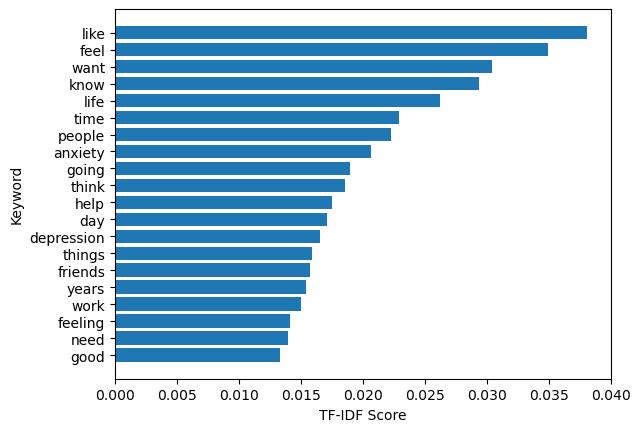

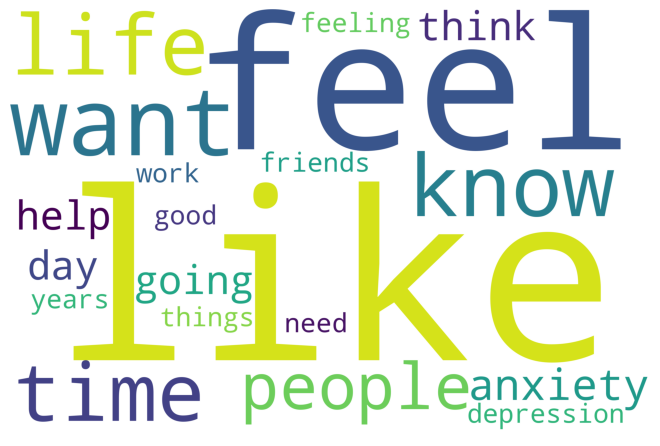

In [20]:
# Load data into a DataFrame
data = pd.read_excel("/kaggle/input/suicide-dataset/majority_labled_data.xlsx")
data = data.head(5000-1)
data['text'] = data['text'].apply(remove_chars)

# Create a TfidfVectorizer object with stop_words
vectorizer = TfidfVectorizer(stop_words='english')

# Fit the vectorizer to the text data
X = vectorizer.fit_transform(data['text'])

# Get the feature names (i.e. the words)
feature_names = vectorizer.get_feature_names_out()

# Get the TF-IDF scores for each word in each document
tfidf_scores = X.toarray()

# Compute the average TF-IDF score for each word
avg_tfidf_scores = tfidf_scores.mean(axis=0)

# Get the top n keywords and their scores
n = 20
excluded_words = ['im','just', 'dont','deleted','really','ive']
top_n_indices = [i for i in avg_tfidf_scores.argsort()[::-1] if feature_names[i] not in excluded_words][:n]
top_n_keywords = [feature_names[i] for i in top_n_indices]
top_n_scores = [avg_tfidf_scores[i] for i in top_n_indices]

# Print the top n keywords and their scores
for keyword, score in zip(top_n_keywords, top_n_scores):
    print(f"{keyword}: {score}")

# Create a horizontal bar chart
plt.barh(top_n_keywords, top_n_scores)
plt.gca().invert_yaxis()
plt.xlabel('TF-IDF Score')
plt.ylabel('Keyword')
plt.show()


# Generate the text for the word cloud
text = ' '.join(top_n_keywords)

# Create a WordCloud object
wordcloud = WordCloud(width=3000, height=2000,
                      prefer_horizontal=1.0,
                      background_color='white',
                      stopwords=excluded_words).generate(text)

# Plot the word cloud
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: FutureWarning: The default value of regex will change from True to False in a future version.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: FutureWarning: The default value of regex will change from True to False in a future version.


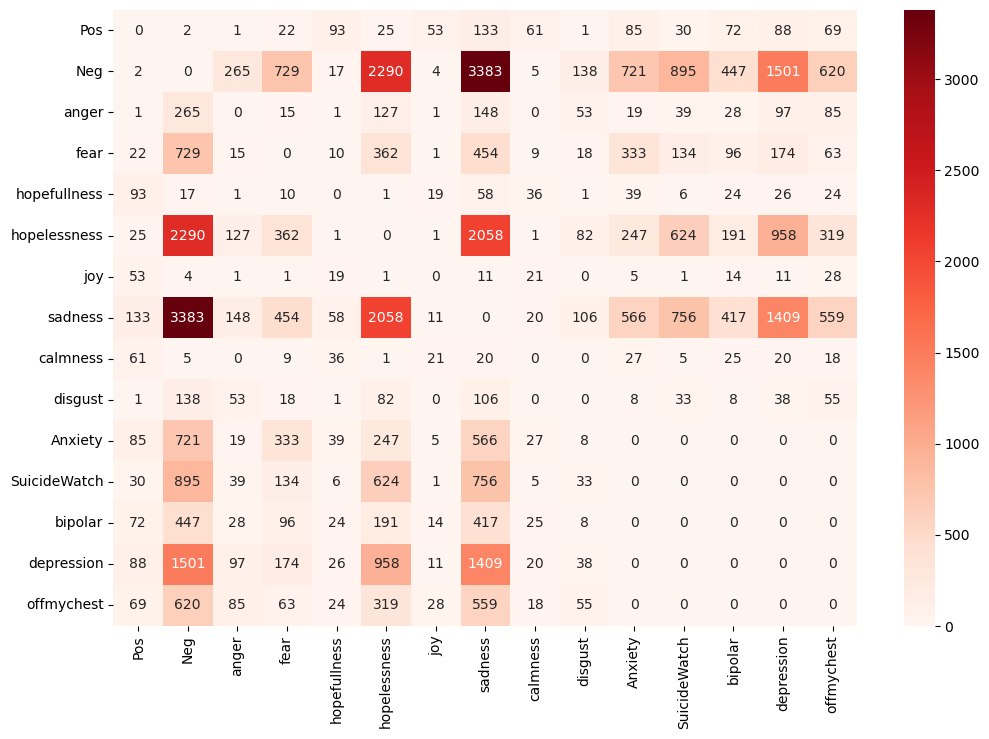

In [25]:
# Load your data into a DataFrame
data = pd.read_excel("/kaggle/input/suicide-dataset/majority_labled_data.xlsx")
data = data.head(5000-1)

# One-hot encode the suicide_label column
suicide_labels = pd.get_dummies(data['suicide_label'], prefix='suicide_label')

# Add the one-hot encoded columns to the DataFrame
data = pd.concat([data, suicide_labels], axis=1)

# Get the column names for the emotion and suicide labels
label_cols = ['Pos', 'Neg', 'anger', 'fear', 'hopefullness', 'hopelessness', 'joy', 'sadness', 'calmness', 'disgust'] + list(suicide_labels.columns)

# Create a co-occurrence matrix
# counts how many times each pair of labels co-occurs in the dataset.

# Get the number of labels
n_labels = len(label_cols)

# Initialize the co-occurrence matrix with zeros with dimensions equal to the number of labels
cooccur_matrix = np.zeros((n_labels, n_labels))

# Iterate over each pair of labels
for i in range(n_labels):
    for j in range(i+1, n_labels):
        # Calculate the number of rows where both labels have a value greater than 0, ie they are releated
        count = ((data[label_cols[i]] > 0) & (data[label_cols[j]] > 0)).sum()
        
        # Store the count in the co-occurrence matrix for both labels since co-occurrence matrix is symmetric
        cooccur_matrix[i, j] = count
        cooccur_matrix[j, i] = count

    

# Create a DataFrame from the co-occurrence matrix
cooccur_df = pd.DataFrame(cooccur_matrix, index=label_cols, columns=label_cols)

# Remove the 'suicide_label_self.' prefix from the row and column labels
cooccur_df.index = cooccur_df.index.str.replace('suicide_label_self.', '')
cooccur_df.columns = cooccur_df.columns.str.replace('suicide_label_self.', '')

# Set the size of the plot
plt.figure(figsize=(12, 8))

# Create a heatmap from the DataFrame and set the fmt parameter to display whole numbers
sns.heatmap(cooccur_df, cmap='Reds', annot=True, fmt='.0f')

# Show the plot
plt.show()